# Setup

In [53]:
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import statsmodels.api as sm

from source.Data import get_maang_data_default
maang = get_maang_data_default()

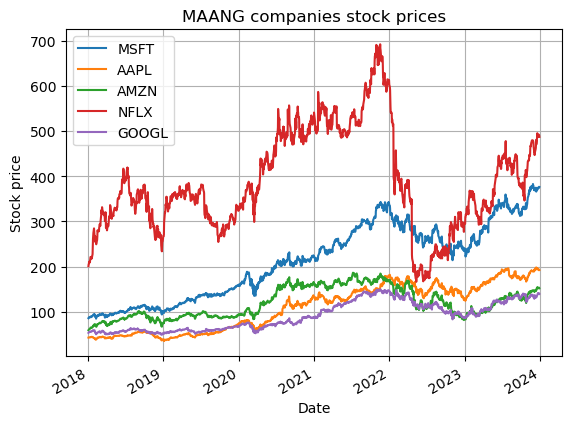

In [54]:
maang.plot(title='MAANG companies stock prices', ylabel='Stock price', xlabel='Date', grid=True);

In [55]:
maang.head()

,MSFT,AAPL,AMZN,NFLX,GOOGL
Date,,,,,
2018-01-02,85.949997,43.064999,59.450500,201.070007,53.660500
2018-01-03,86.349998,43.057499,60.209999,205.050003,54.576000
2018-01-04,87.110001,43.257500,60.479500,205.630005,54.787998
2018-01-05,88.190002,43.750000,61.457001,209.990005,55.514500
2018-01-08,88.279999,43.587502,62.343498,212.050003,55.710499


# Séries temporelles linéaires

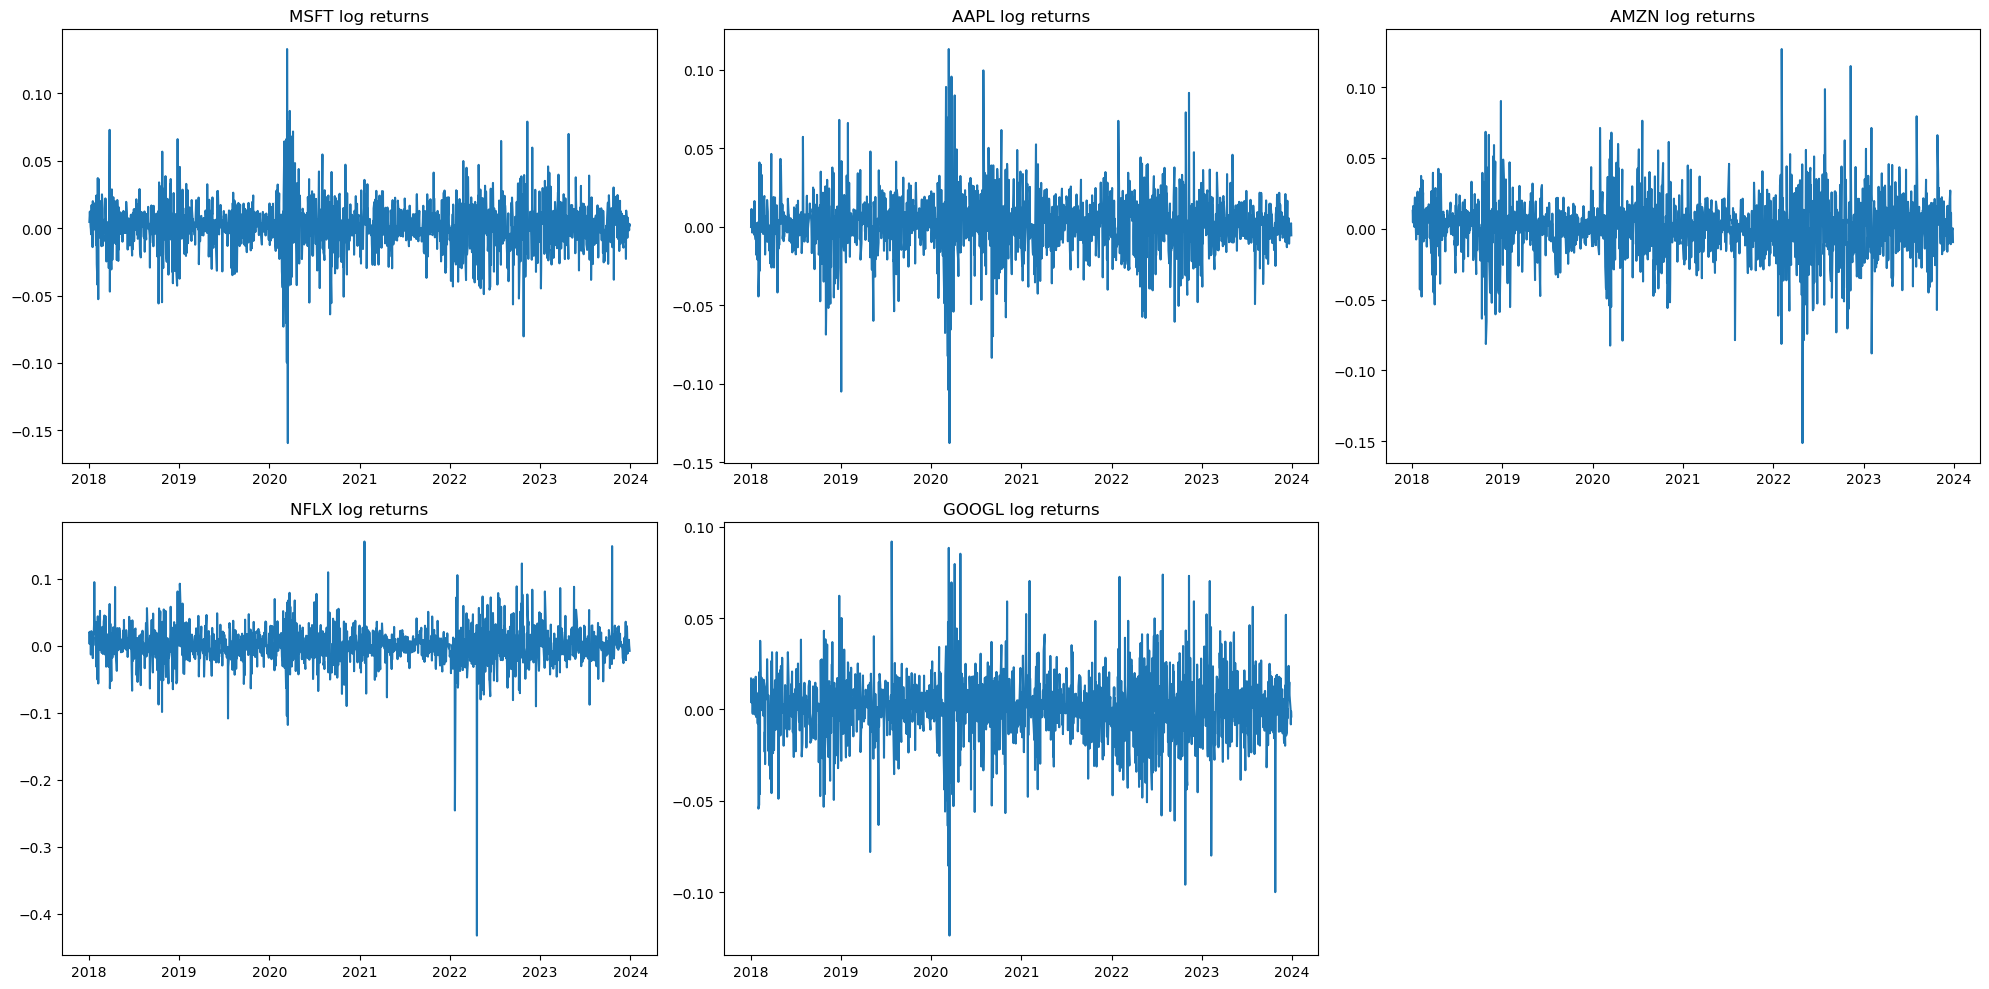

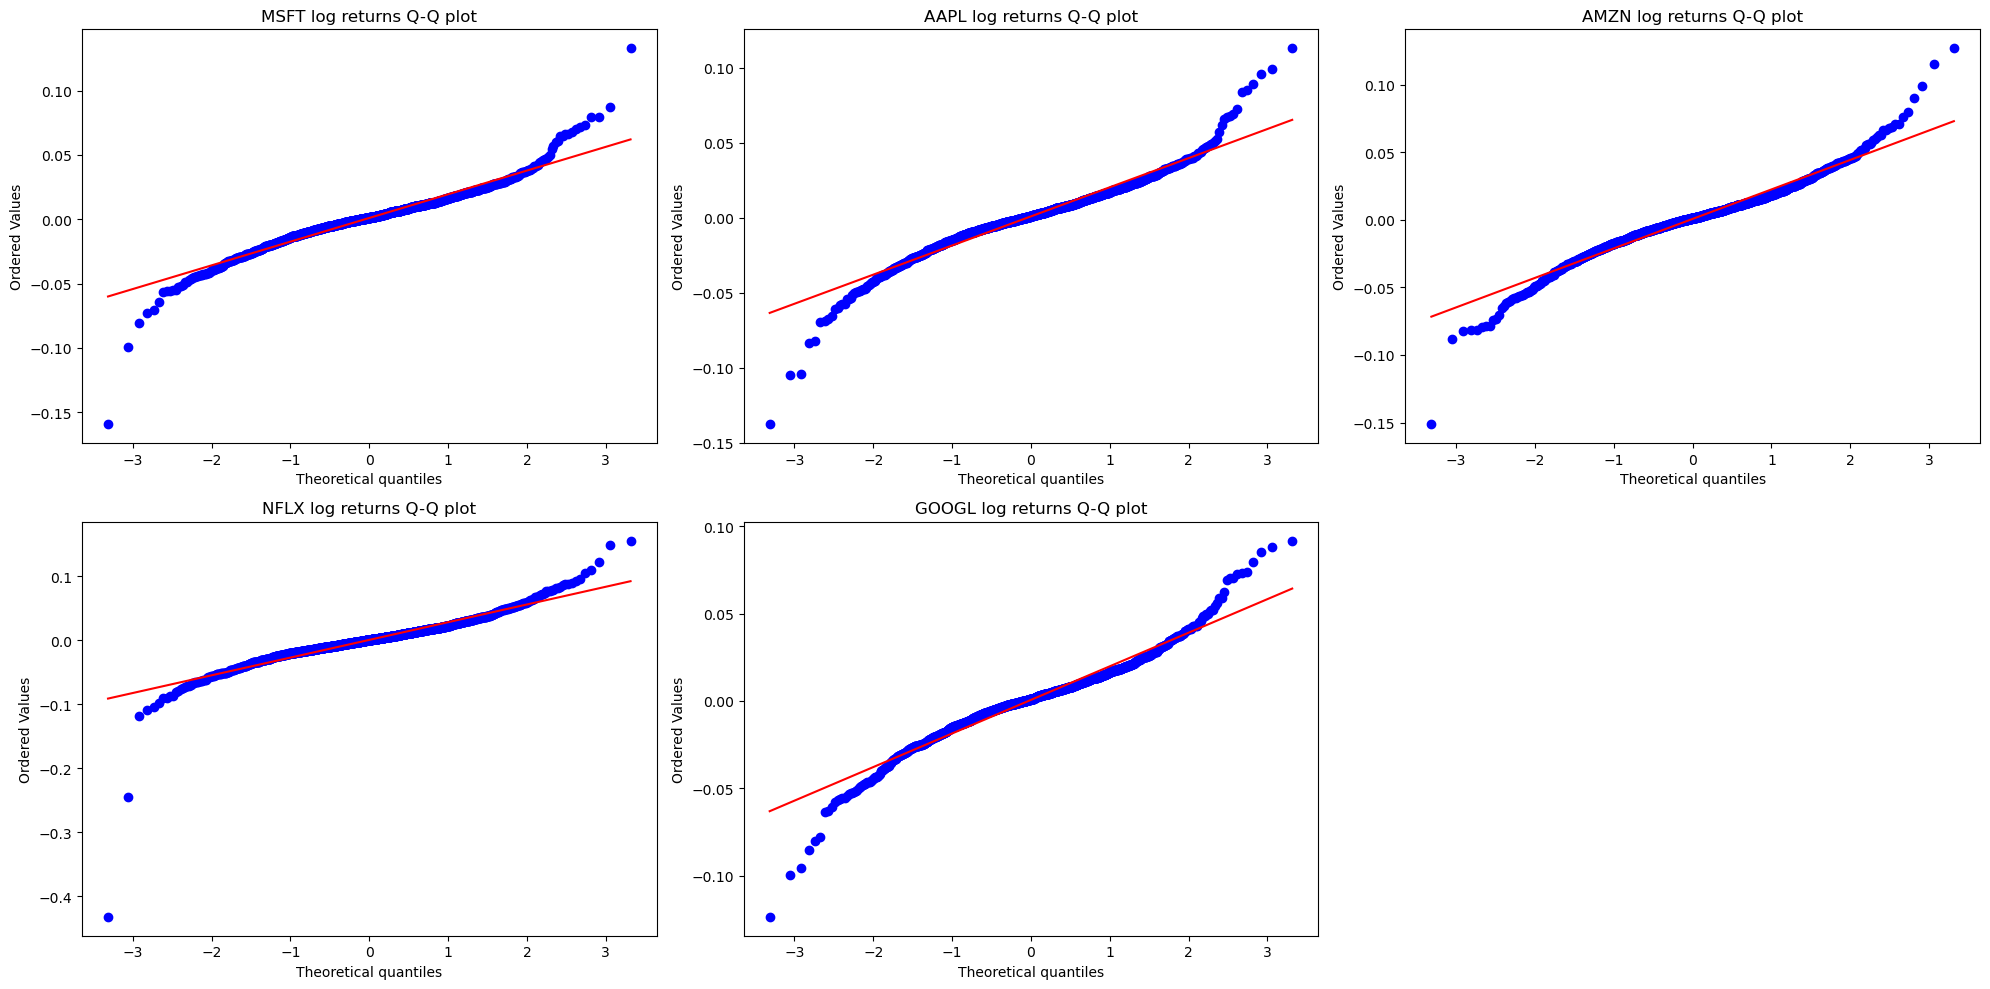

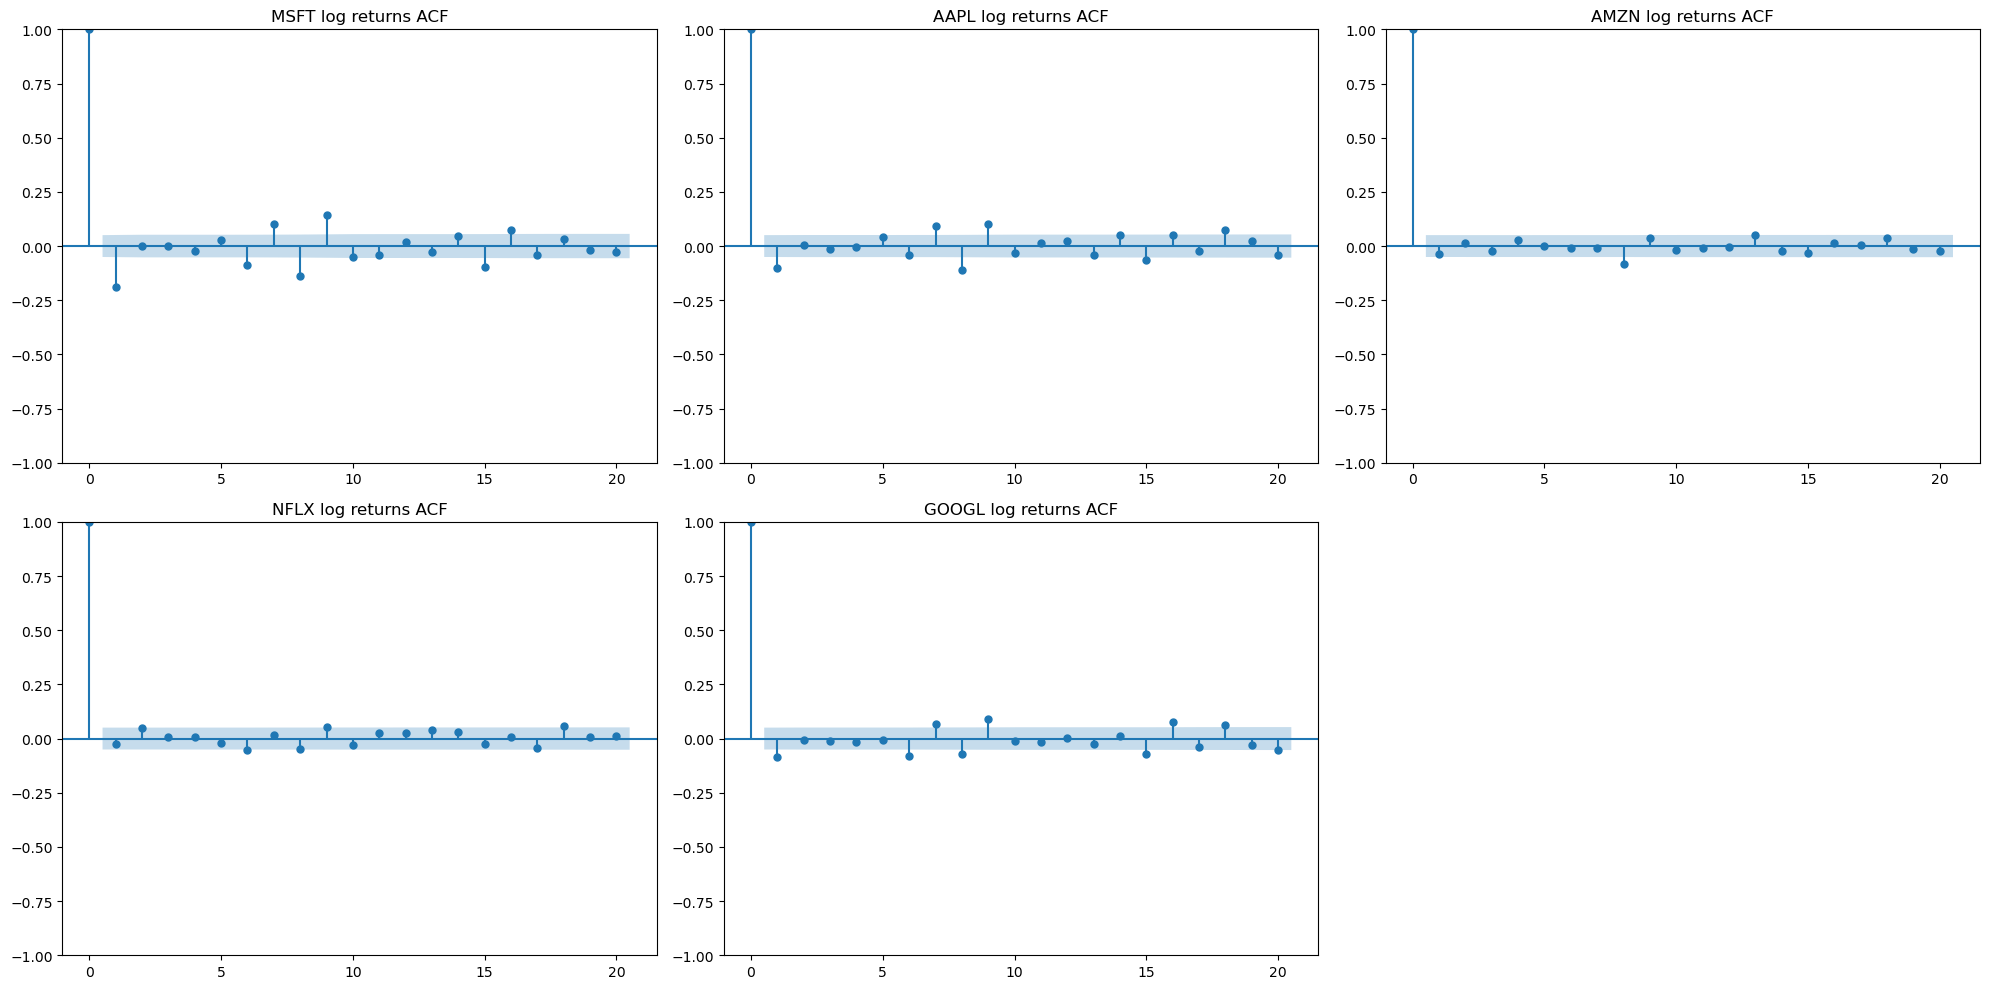

In [60]:
maang_log_returns = np.log(maang / maang.shift(1)).dropna()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    plt.plot(maang_log_returns[stock])
    plt.title(stock + ' log returns')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sps.probplot(maang_log_returns[stock], plot=plt, dist='norm')
    plt.title(stock + ' log returns Q-Q plot')
plt.tight_layout()
plt.show()

plt.figure(figsize=(20, 10))
for i, stock in enumerate(maang_log_returns.columns):
    plt.subplot(2, 3, i + 1)
    sm.graphics.tsa.plot_acf(maang_log_returns[stock], lags=20, ax=plt.gca())
    plt.title(stock + ' log returns ACF')
plt.tight_layout()
plt.show()

In [57]:
for stock in maang_log_returns.columns:
    kurtosis = np.mean((maang_log_returns[stock] - maang_log_returns[stock].mean()) ** 4) / np.var(maang_log_returns[stock]) ** 2
    normalized_kurtosis = kurtosis - 3
    print(f'Kurtosis normalisé pour {stock}:\t {round(kurtosis, 3)}')

Kurtosis normalisé pour MSFT:	 9.835
Kurtosis normalisé pour AAPL:	 8.049
Kurtosis normalisé pour AMZN:	 6.913
Kurtosis normalisé pour NFLX:	 36.722
Kurtosis normalisé pour GOOGL:	 6.828


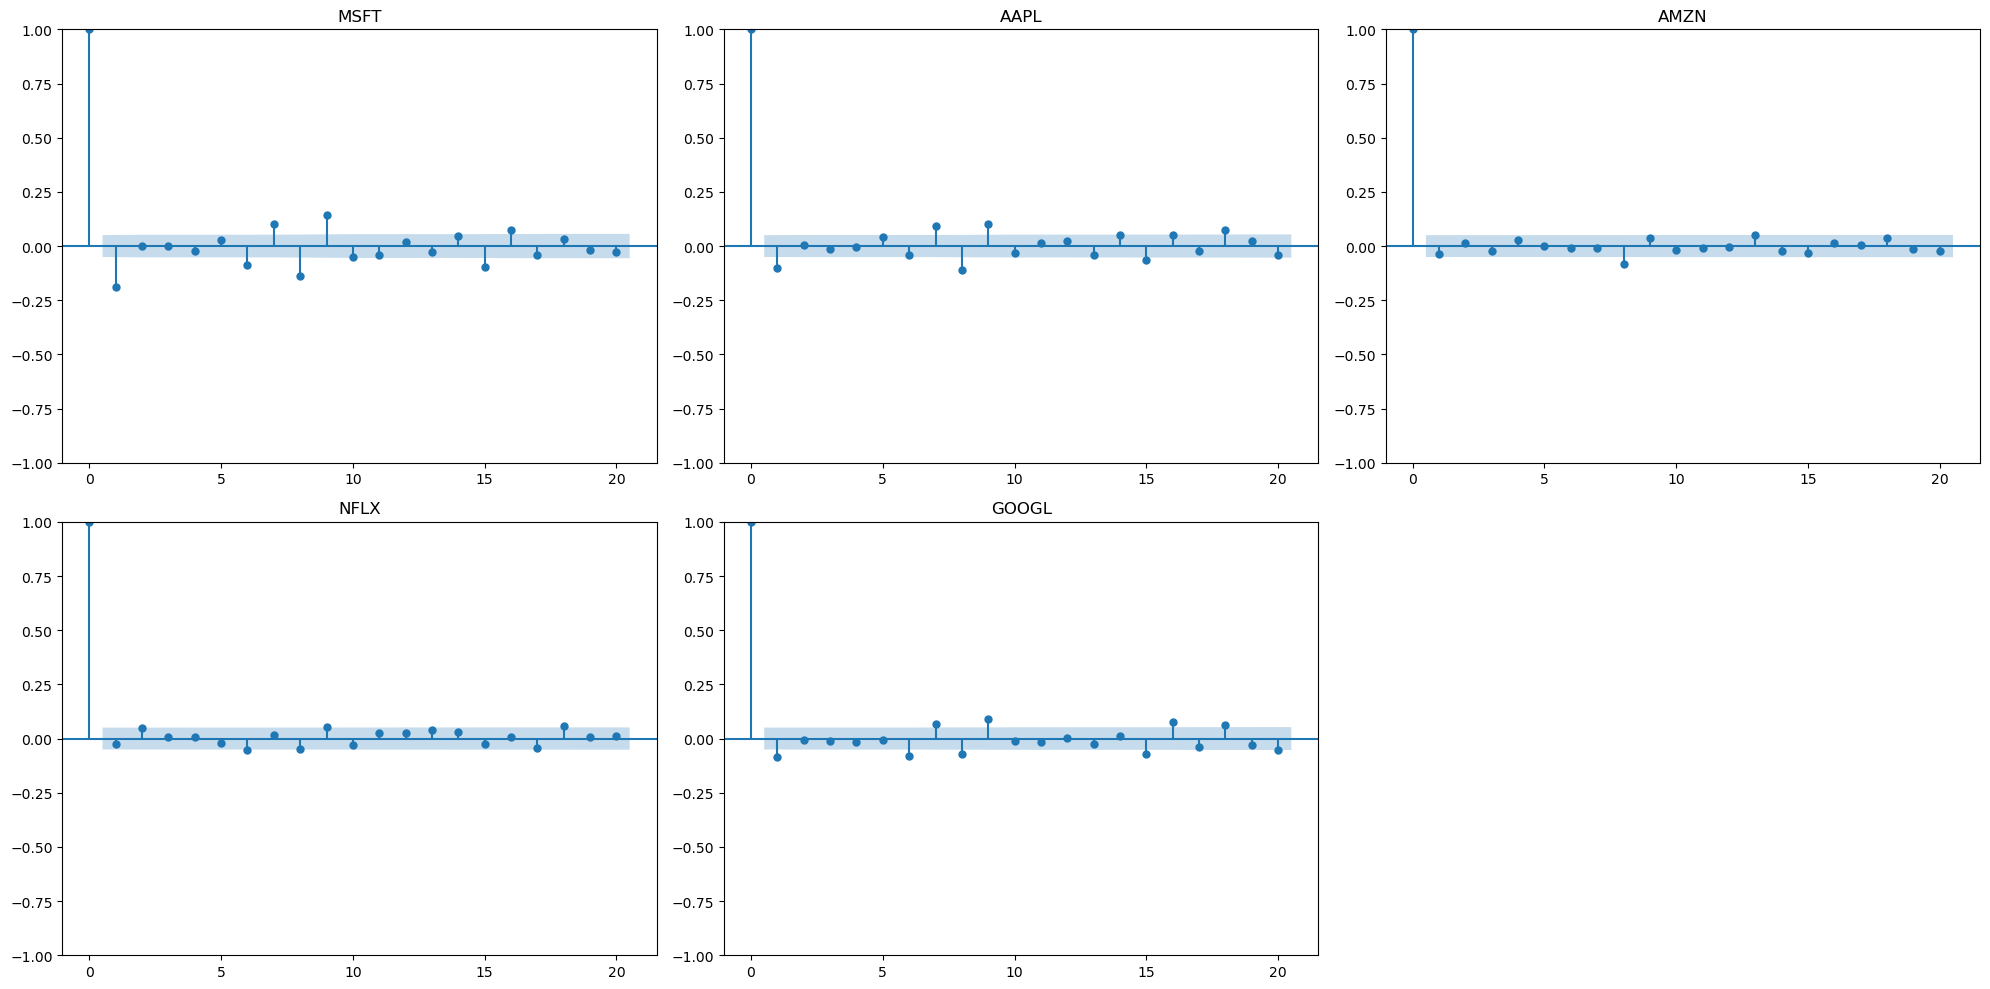

In [58]:
# autocorrelation plots for each stock
